# INM430 Coursework Final Submission Part-2 - Analysis Files

This notebook is to support the written report pdf file. This notebook documents all the steps required for the project submission as listed in the table of contents below.

## Table of Contents
1. [Setup](#setup)
2. [Loading the Data](#loading-the-data)
3. [Data Exploration](#data-exploration)
4. [Baseline Model](#baseline-model)
5. [Analysis](#analysis)
    * 5.1. [TF-IDF Representation](#tf-idf-representation)
    * 5.2. [Doc2Vec Representation](#doc2vec-representation)
6. [Evaluation](#evaluation)
7. [Miscellaneous](#miscellaneous)

<a name="setup"></a>
## 1. Setup

Hide errors for presentation purposes

In [14]:
import warnings
warnings.filterwarnings('ignore')

Import dependencies

In [2]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt
import multiprocessing
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from pipelinehelper import PipelineHelper
import re
import scipy
import seaborn as sns
from sklearn import utils
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import LinearSVC

%matplotlib inline

<a name="loading-the-data"></a>
## 2. Loading the Data

The data was collected through scraping a number of different websites as discussed in the written report. The scripts written for this data collection process are found in the scripts folder. Due to some parsing errors with the web scraper, some lyrics were not returned to appear as empty strings or null values in the CSV file.

In [3]:
tracks_by_artist = pd.read_csv("./data/tracks_with_lyrics_for_top_10_artists.csv")
tracks_by_artist = tracks_by_artist[~tracks_by_artist["lyrics"].isnull()]

In [4]:
tracks_by_artist.head()

,artist,album,track,lyrics
0,T.I.,Trap Muzik,I Can't Quit,"[Intro]\nHuh, hell nah, I can't quit\nHell nah..."
1,T.I.,Trap Muzik,Be Easy,"[Intro]\nUh-uh, uh-uh, uh\nAye, where the pian..."
2,T.I.,Trap Muzik,No More Talk,[Verse 1]\nI'm either running for my life or I...
3,T.I.,Trap Muzik,Doin My Job,"[T.I. - talking]\nAy I'm working here, know wh..."
4,T.I.,Trap Muzik,24's,"[Intro]\nYeah\nFor all my real ATL niggas, tha..."


In [5]:
tracks_by_artist.shape

(679, 4)

Have a total of 679 tracks with lyrics with artist name and album title as additional metadata

<a name="data-exploration"></a>
## 3. Data Exploration

The following illustrates the break down of the number of tracks by artist considered in this project. This has implications for the evaluation metrics I will report in the investigation. The following considerations are important to decide the evaluation metrics,

* The project deals with a supervised, multiclass classification task,
* The classes in the original dataset are unbalanced.

For these reasons, I will report the precision, recall, and weighted fscore for each model. Together, these metrics do a better job of indicating the overall accuracy of a classifier, whereas with accuracy alone, there is a risk that we are not correctly identifying a good-performing classifier but rather just one that is biased towards the more populated classes. 

Text(0.5,1,'Total Number of Tracks with Lyrics by Artist')

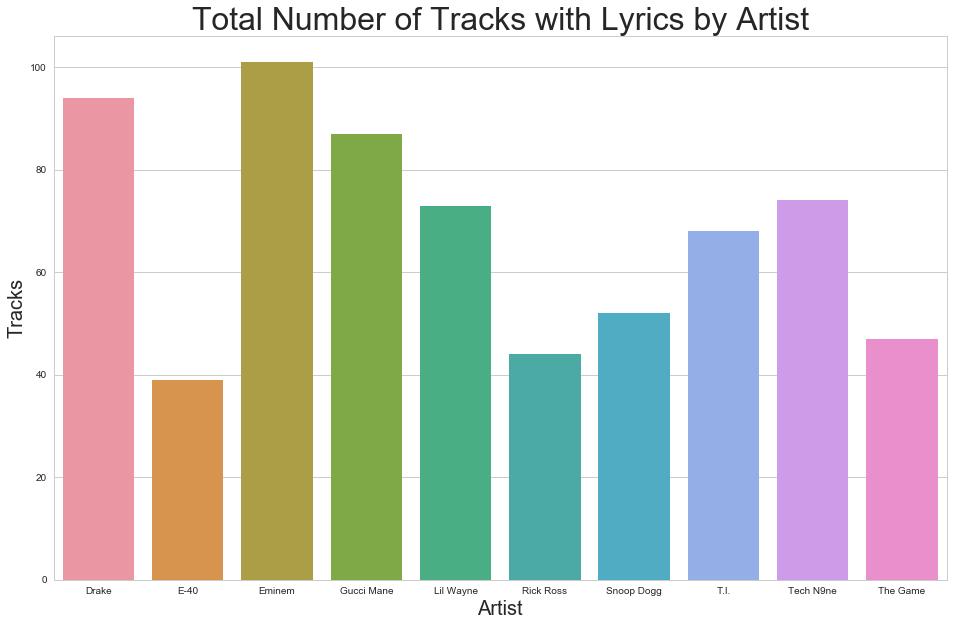

In [6]:
total_tracks_by_artist = tracks_by_artist.groupby("artist").agg("count")[["track"]]
total_tracks_by_artist = total_tracks_by_artist.reset_index()
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16,10))
sns.barplot(ax=ax, x="artist", y="track", data=total_tracks_by_artist)
ax.set_xlabel("Artist", fontsize=20)
ax.set_ylabel("Tracks", fontsize=20)
ax.set_title("Total Number of Tracks with Lyrics by Artist", fontsize=32)

Same as above but with numbers

In [7]:
tracks_by_artist.groupby("artist")["track"].agg("count")

artist
Drake          94
E-40           39
Eminem        101
Gucci Mane     87
Lil Wayne      73
Rick Ross      44
Snoop Dogg     52
T.I.           68
Tech N9ne      74
The Game       47
Name: track, dtype: int64

<a name="baseline-model"></a>
## 4. Baseline Model

For a like-to-like comparison with future text representations and models, this section reports on the testing results of a logistic regression classifier using a Bag-of-Words (BOW) representation. This is very basic but will help indicate whether choices for later models help to improve on the overall classification task. BOW simply counts the frequency of words in each document as a way of representing the documents, where in this case the "documents" are the individual tracks. This introduces a lot of simplifications, which the other text representations approaches below try to address. 

The fundamental task for this project is a multiclass classification, where the artist name is the target label, all the other features are inputs to the model.

To get an indication of the effectiveness of a given classifier, we need to perform a test train split on the original dataset. This is to achieve a better measure of the classifier's performance, as the test set will contain data points that are not in the training set. Or in other words, the classifier will not simply rely on overtraining with respect to the training set. Some other things to note, to make sure the test train split is repeatable if required, I am specifying a random state seed. As this is a multiclass dataset, I am specifying a stratified split using the artist name as the class label.

In [8]:
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34, stratify=tracks_by_artist["artist"])
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

Here we initialise the BOW model, build vocabulary from training data, and transform both training and test data to BOW representation. In this step, common words or "stop words" are removed according to a standard corpus, as well as using the standard NLTK tokenizer to parse tokens i.e. words, characters from the raw lyrics. It is a common strategy to remove stop words as these do not typically aid the classifier to choose between class labels, but rather just increase the dimensionality of vector space and take up more memory. I've also used the standard NLTK tokenizer simply because it does a good enough job at identifying word tokens as well as remove nonalphabetic characters such as numbers and punctuation.

It should also be mentioned here that I will not stem the words from the lyrics. Although this means that the bow vectors will be larger, as words with similar spelling will instead be mapped to their own unique index e.g. stop, stopping will be treated separately, it means we can get a better grasp of the actual written language being used. This is perhaps especially true for song lyrics where spelling is often non-standard, and slang and other neologisms are frequently used.

In [9]:
def tokenize(lyrics):
    tokens = word_tokenize(lyrics)
    return [token.lower() for token in tokens if token.isalpha()]

In [10]:
bow = CountVectorizer(stop_words=ENGLISH_STOP_WORDS, tokenizer=tokenize)
X_train_bow = bow.fit_transform(X_train["lyrics"])
X_test_bow = bow.transform(X_test["lyrics"])

In [11]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(475, 13488)
(204, 13488)


The BOW vectors have over 13,000 components

Perform grid search cross-validation to find the optimal value for the C parameter. In this step, grid search works through the training data, splitting it into a training set and validation set accorinding to the "cv" parameter. By finding the average of these individual runs, it can find the best hyperparamter set. The predictions are then generated from the model with the optimal value for C.  

In [12]:
param_grid = {"C": [1e0, 1e1, 1e2, 1e3]}

logreg = GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid)
logreg.fit(X_train_bow, y_train.ravel())
y_pred = logreg.predict(X_test_bow)

prfs = precision_recall_fscore_support(y_test.ravel(), y_pred, average='weighted', labels=np.unique(y_pred))

In [15]:
logreg.grid_scores_

[mean: 0.74526, std: 0.03988, params: {'C': 1.0},
 mean: 0.74105, std: 0.03297, params: {'C': 10.0},
 mean: 0.73263, std: 0.03770, params: {'C': 100.0},
 mean: 0.72421, std: 0.02992, params: {'C': 1000.0}]

Reported results for baseline model.

In [16]:
print('Testing Precision: {}'.format(prfs[0]))
print('Testing Recall: {}'.format(prfs[1]))
print('Testing FScore: {}'.format(prfs[2]))
print("Logistic Regression Param C: {}".format(logreg.best_params_["C"]))

Testing Precision: 0.7237750954778471
Testing Recall: 0.7107843137254902
Testing FScore: 0.7070473877714213
Logistic Regression Param C: 1.0


These are the scores to beat!

<a name="analysis"></a>
## 5. Analysis

Models to be considered,

* Logistic Regression 
* Linear SVM

This is because these models have generally been used by previous authors in this task and due to their effectiveness for multilcass problems in general. Additionally, in the case of logistic regression, this provides a direct comparison with the baseline model.

The below function "best_results_by_model" is a simple way to extract the equal best performing classifier for each text representation strategy. For each classifier it finds one with the equal best mean cross-validation score against the test set considered. ("Equal best" because it doesn't consider the case of more than one set of hyperparameters for a given classifier producing the same mean test score.)

In [17]:
# Helper function
def best_results_by_model(grid_scores):
    
    best_results_by_model = {}
    for score in grid_scores:
        model_name = score[0]["classifier__selected_model"][0]
        if (model_name not in best_results_by_model) or (score[1] > best_results_by_model[model_name]["mean"]):
            best_results_by_model[model_name] = {
                "params": score[0],
                "mean": score[1],
                "results": score[2],
            }
    
    return best_results_by_model   

#### Feature engineering

The features I will be considering in this project are listed below. Starting only with the raw lyrics collected by scraping an external website I had to derive all the features used in this project following a process of feature engineering.

* Vectorised track lyrics: for each text representation strategy, I will vectorise the raw lyrics according to one of two approaches: TF-IDF and Doc2Vec. This will be the main variable in the project.
* Track line count: the total number of lines in each track, breaking on newline characters "\n"
* Average line length: the number of words in each line of lyrics, averaged for each track
* Unique word proportion: the proportion of unique words out of the total number of words in a given track
* Song structure: a TF-IDF vector representation of the song structure. This follows by simply reading in the labels corresponding to different 

The features considered in this study were chosen either because something similar was used in a related paper, or because they were something I have not otherwise come across in the literature. Overall, I feel like these do a good job at characterising tracks at an artist-level, for instance in the project progress submission notebook I found that "unique word proportion" did a fairly good job at characterising artists already.

Below are custom transformers used by the pipeline constructor further below. In general these perform feature engineering tasks discussed above, with the exception of "LyricsExtractor", "VectorExtractor", "ArrayCaster", and "ListCaster". The specific task of each extractor is written as a comment above the given extractor.

In [18]:
# Custom Transformers

# Return "lyrics" Series as an array
class LyricsExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].values

# Return "vectors" Series as an array
class VectorExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["vectors"].values

# This is a helper method to help the pipeline handle sparse arrays
class ArrayCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return np.transpose(np.matrix(data))

# This is a helper class that transforms the Doc2Vec song vectors into a form that the classifiers expect
class ListCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data.tolist()

# For each track, find the number of lines
class LineCountExtractor(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].str.split("\n").apply(len)

# For each track, find the average line length
class AverageLineLengthExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].str.split("\n").apply(lambda lines: sum(map(len,lines))/len(lines))

# For each track, return a list containing terms describing each verse. For text 
class SongStructureExtractor(BaseEstimator, TransformerMixin):

    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].apply(lambda lyrics: " ".join(re.findall(r"\[(.*)\]", lyrics)))

# For each track, find the proportion of unique words as a proportion of the total words used
class UniqueWordProportionExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data["lyrics"].apply(lambda lyrics: self.__prop_unique_words(lyrics))
    
    def __prop_unique_words(self, lyrics):
        return self.__get_unique_word_count(lyrics) / self.__get_total_word_count(lyrics)
    
    def __get_total_word_count(self, lyrics):
        return len(re.split(" |\n|", lyrics))
    
    def __get_unique_word_count(self, lyrics):
        return len(set(re.split(" |\n|", lyrics)))

Pipelines are a convenient way to apply a series of repeatable transformations in sequence. Using the transformers abofe, each pipeline below specifies the feature engineering process

In [19]:
# Pipelines
line_count = Pipeline([
                ("get_line_count", LineCountExtractor()),
                ("caster", ArrayCaster())
            ])

average_line_length = Pipeline([
                ("get_average_line_length", AverageLineLengthExtractor()),
                ("caster", ArrayCaster())
            ])

unique_word_proportion = Pipeline([
                ("get_unique_word_proportion", UniqueWordProportionExtractor()),
                ("caster", ArrayCaster())
            ])

song_structure = Pipeline([
                ("get_song_strucutre", SongStructureExtractor()),
                ("tfidf", TfidfVectorizer(lowercase=False)),
            ])

In [20]:
# TF-IDF specific 
song_vectors = Pipeline([
                ("lyrics", LyricsExtractor()),
                ("tfidf", TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, tokenizer=tokenize)),
            ])

A FeatureUnion is a way bringing together mulitple heterogeneous features in parallel, in this case the five different features created with the above transformers.

In [21]:
featureunion = FeatureUnion([
    ("line_count", line_count),
    ("song_vectors", song_vectors),
    ("average_line_length", average_line_length),
    ("unique_word_proportion", unique_word_proportion),
    ("song_structure", song_structure)
])

There's a lot going on here. Below is the complete pipeline to used for both text representations considered. This puts together the feature union above with the three classifiers to be considered in turn. Here I am using a third-party to enable swapping between named steps in the pipeline as part of the grid search cross-validation, in this case swapping between each of the three classifiers.

In [22]:
pipeline = Pipeline([
    ("featureunion", featureunion),
    ("classifier", PipelineHelper([
        ("LogisticRegression", LogisticRegression()),
        ("LinearSVC", LinearSVC())
    ]))
])

Finally, I have defined a dictionary containing possible transformer weights and other parameters. This are for use by the grid search cross-validation process, so we can consider each of the three classifiers in turn and return the parameters for the best performing classifier.

The transformer weights are simply multiplcative factors that tune the contribution of each feature to the final classifier prediction. For the sake of simplicity I have only considered weights of either 1 or 0 i.e. either the feature does or doesn't contribute to the prediction. With this in mind, there could be up to 31 possible combinations of transformer weights (2^5 for each feacture, less 1 for case of all weights being 0). Due to time constraints I have limited myself to a subset of of transformer weights, where at least one feature is given by song_vectors. This is because this feature is of most interest in this project, and allows for a more meaningful comparison to the baseline BOW model.

I have also tried to limit the vocabulary by terms that either appear very frequently or very infrequently. For very frequent terms, their inclusion usually does not help classifier accuracy, as like stop words, they do not indicate characteristic elements of a particular artists. Infrequently occuring terms, on the other hand, can lead to overtraining as the model may trained to classify by a single term or so.

In [23]:
param_grid = {
    "featureunion__transformer_weights": [
        # one feature only
        {"song_vectors":1,"line_count":0, "average_line_length":0, "unique_word_proportion":0, "song_structure":0},
        # four features
        {"song_vectors":1,"line_count":0, "average_line_length":1, "unique_word_proportion":1, "song_structure":1},
        # five features
        {"song_vectors":1,"line_count":1, "average_line_length": 1, "unique_word_proportion": 1, "song_structure": 1},
    ],
    "featureunion__song_vectors__tfidf__max_df": [0.7, 0.9],
    "featureunion__song_vectors__tfidf__min_df": [1, 5],
    "classifier__selected_model": pipeline.named_steps["classifier"].generate({
        "LogisticRegression__C": [1e0, 1e1],
        "LinearSVC__C": [1e0, 1e1]
    })
}

<a name="tf-idf-representation"></a>
### 5.1. TF-IDF Representation

The first text representation to be considered will be TF-IDF short for term frequency-inverse document frequency. In this representation, vectors for each song are created by scoring the number of times a given word appears in a song (term frequency, which is basically BOW), with the inverse of the number of documents that word appears in. Although like BOW, this approach loses contextual information, i.e. where a given word appeared in relation to another, it does a much better job at capturing the relative importance of a given word for a given song. By using the inverse document frequency, words that only appear in a handful of documents are promoted over words that appear in multiple documents. With this approach, we can better find words that characterise an particular track or artists.

Putting everything above together, will run through the pipeline specified above, with the provided set of hyperparameters. Using the GridSearchCV class, this will perform grid search cross-validation as per the the baseline model above.

In [24]:
tfidf_gs_clf = GridSearchCV(pipeline, param_grid, cv=5, verbose=1)

This performs a test train split exactly as per the baseline model. Repeat is here to ensure we get the same initial dataset.

In [25]:
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34, stratify=tracks_by_artist["artist"])
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

In [26]:
tfidf_gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 14.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('line_count', Pipeline(memory=None,
     steps=[('get_line_count', LineCountExtractor()), ('caster', ArrayCaster())])), ('song_vectors', Pipeline(memory=None,
     steps=[('lyrics', LyricsExtractor()), ('tfidf', TfidfVectorizer...andom_state=None, tol=0.0001,
     verbose=0)},
        include_bypass=False, selected_model=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'featureunion__transformer_weights': [{'song_vectors': 1, 'line_count': 0, 'average_line_length': 0, 'unique_word_proportion': 0, 'song_structure': 0}, {'song_vectors': 1, 'line_count': 0, 'average_line_length': 1, 'unique_word_proportion': 1, 'song_structure': 1}, {'song_vectors': 1, 'l... 1.0}), ('LogisticRegression', {'C': 10.0}), ('LinearSVC', {'C': 1.0}), ('LinearSVC', {'C': 10.0})]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

Full set of scores

In [27]:
tfidf_gs_clf.grid_scores_

[mean: 0.67158, std: 0.02807, params: {'classifier__selected_model': ('LogisticRegression', {'C': 1.0}), 'featureunion__song_vectors__tfidf__max_df': 0.7, 'featureunion__song_vectors__tfidf__min_df': 1, 'featureunion__transformer_weights': {'song_vectors': 1, 'line_count': 0, 'average_line_length': 0, 'unique_word_proportion': 0, 'song_structure': 0}},
 mean: 0.64632, std: 0.06213, params: {'classifier__selected_model': ('LogisticRegression', {'C': 1.0}), 'featureunion__song_vectors__tfidf__max_df': 0.7, 'featureunion__song_vectors__tfidf__min_df': 1, 'featureunion__transformer_weights': {'song_vectors': 1, 'line_count': 0, 'average_line_length': 1, 'unique_word_proportion': 1, 'song_structure': 1}},
 mean: 0.67158, std: 0.05484, params: {'classifier__selected_model': ('LogisticRegression', {'C': 1.0}), 'featureunion__song_vectors__tfidf__max_df': 0.7, 'featureunion__song_vectors__tfidf__min_df': 1, 'featureunion__transformer_weights': {'song_vectors': 1, 'line_count': 1, 'average_line

For each classifier, report the equal best performing set of hyperparameters using the helper method.

In [61]:
best_results_by_model(tfidf_gs_clf.grid_scores_)

{'LinearSVC': {'mean': 0.8084210526315789,
  'params': {'classifier__selected_model': ('LinearSVC', {'C': 1.0}),
   'featureunion__song_vectors__tfidf__max_df': 0.7,
   'featureunion__song_vectors__tfidf__min_df': 5,
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_structure': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.90196078, 0.75      , 0.75268817, 0.7826087 , 0.84782609])},
 'LogisticRegression': {'mean': 0.7957894736842105,
  'params': {'classifier__selected_model': ('LogisticRegression', {'C': 10.0}),
   'featureunion__song_vectors__tfidf__max_df': 0.9,
   'featureunion__song_vectors__tfidf__min_df': 5,
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_structure': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.87254902, 0.73958333, 0.75268817, 0.7826087 , 0.82608696])}}

Check details relating to TF-IDF parameters for most successful model. The vector space has a dimensionality of 2,677 much smaller than the baseline model. This is in a large part due to limiting vocabulary using min_df/max_df.

In [52]:
tfidf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, tokenizer=tokenize, min_df=5, max_df=0.7)
tfidf.fit_transform(X_train["lyrics"])
tfidf_vocab = tfidf.get_feature_names()
len(tfidf.get_feature_names())

2677

In [29]:
y_pred = tfidf_gs_clf.predict(X_test)

print('Testing Precision: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print('Testing Recall: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))
print('Testing FScore: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))

Testing Precision: 0.7881880278506576
Testing Recall: 0.7794117647058824
Testing FScore: 0.7744397900610812


<a name="doc2vec-representation"></a>
### 5.2. Doc2Vec Representation

The final text representation we will consider in this notebook is know as Doc2Vec. Without going into too much detail, this approach tries to predict a given word in the text document using both the set of surrounding words as well as the document feature vector. Most importantly for us, in contrast to TF-IDF, Doc2Vec learns the context of the word, so we determine both syntactic and semantic meaning.

The specific version considered here is known as distributed bag-of-words (DBOW).

Re-perform test train split on original dataframe, but with same random seed, as above.

In [30]:
train, test = train_test_split(tracks_by_artist, test_size=0.3, random_state=34, stratify=tracks_by_artist["artist"])
y_train, X_train = train["artist"], train
y_test, X_test = test["artist"], test

For both the test and training set, create a tagged set of lyrics using artists names. This "tagged" lists are used as input for the Doc2Vec model.

In [31]:
train_tagged = [TaggedDocument(words=tokenize(X_train["lyrics"].tolist()[idx]), tags=y_train.tolist()[idx]) for idx, _ in enumerate(y_train)]
test_tagged = [TaggedDocument(words=tokenize(X_test["lyrics"].tolist()[idx]), tags=y_test.tolist()[idx]) for idx, _ in enumerate(y_test)]

The following two code cellls build the DBOW Doc2Vec model, training on the traing_tagged vocabulary. Due to time constraints, I did not choose to vary the vector size (the dimensionality of the feature vectors). The number is of the same order of magnitude as the TF-IDF vocabulary above and gives results competitive with the TF-IDF representation.

In [32]:
model_dbow = Doc2Vec(dm=0, vector_size=1000, sample=0, workers=multiprocessing.cpu_count())
model_dbow.build_vocab(train_tagged)

In [33]:
max_epochs = 30
for epoch in range(max_epochs):
    model_dbow.train(utils.shuffle(train_tagged), total_examples=model_dbow.corpus_count, epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [34]:
# This is the total vocabulary used across all feature vectors
len(model_dbow.wv.vocab)

3448

Get entire trained vocabulary.

In [35]:
dbow_vocab = list(model_dbow.wv.vocab.keys())

Now need to add feature vectors to test, training set.

In [36]:
X_train["vectors"] = train_tagged
X_test["vectors"] = test_tagged

Remove TF-IDF specific parameters from the parameter grid.

In [37]:
param_grid = {
    "featureunion__transformer_weights": [
        # one feature only
        {"song_vectors":1,"line_count":0, "average_line_length":0, "unique_word_proportion":0, "song_structure":0},
        # four features
        {"song_vectors":1,"line_count":0, "average_line_length":1, "unique_word_proportion":1, "song_structure":1},
        # five features
        {"song_vectors":1,"line_count":1, "average_line_length": 1, "unique_word_proportion": 1, "song_structure": 1},
    ],
    "classifier__selected_model": pipeline.named_steps["classifier"].generate({
        "LogisticRegression__C": [1e0, 1e1],
        "LinearSVC__C": [1e0, 1e1]
    })
}

This is just another custom transformer to get the track feature vectors into a form the model expects. This is the only change to the above pipeline.

In [38]:
class ListCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data.tolist()

song_vectors = Pipeline([
                ("vector", VectorExtractor()),
                ("tolist", ListCaster()),
            ])

Repeat all the steps as per section 5.1

In [39]:
doc2vec_gs_clf = GridSearchCV(pipeline, param_grid, cv=5)

In [40]:
doc2vec_gs_clf.fit(X_train, list(y_train))

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('line_count', Pipeline(memory=None,
     steps=[('get_line_count', LineCountExtractor()), ('caster', ArrayCaster())])), ('song_vectors', Pipeline(memory=None,
     steps=[('lyrics', LyricsExtractor()), ('tfidf', TfidfVectorizer...andom_state=None, tol=0.0001,
     verbose=0)},
        include_bypass=False, selected_model=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'featureunion__transformer_weights': [{'song_vectors': 1, 'line_count': 0, 'average_line_length': 0, 'unique_word_proportion': 0, 'song_structure': 0}, {'song_vectors': 1, 'line_count': 0, 'average_line_length': 1, 'unique_word_proportion': 1, 'song_structure': 1}, {'song_vectors': 1, 'l... 1.0}), ('LogisticRegression', {'C': 10.0}), ('LinearSVC', {'C': 1.0}), ('LinearSVC', {'C': 10.0})]},
       pre_dispatch='2*n_jobs', refit=True, return_tra

Full set of grid scores.

In [41]:
doc2vec_gs_clf.grid_scores_

[mean: 0.67579, std: 0.02280, params: {'classifier__selected_model': ('LogisticRegression', {'C': 1.0}), 'featureunion__transformer_weights': {'song_vectors': 1, 'line_count': 0, 'average_line_length': 0, 'unique_word_proportion': 0, 'song_structure': 0}},
 mean: 0.65474, std: 0.06538, params: {'classifier__selected_model': ('LogisticRegression', {'C': 1.0}), 'featureunion__transformer_weights': {'song_vectors': 1, 'line_count': 0, 'average_line_length': 1, 'unique_word_proportion': 1, 'song_structure': 1}},
 mean: 0.67368, std: 0.05533, params: {'classifier__selected_model': ('LogisticRegression', {'C': 1.0}), 'featureunion__transformer_weights': {'song_vectors': 1, 'line_count': 1, 'average_line_length': 1, 'unique_word_proportion': 1, 'song_structure': 1}},
 mean: 0.76842, std: 0.05114, params: {'classifier__selected_model': ('LogisticRegression', {'C': 10.0}), 'featureunion__transformer_weights': {'song_vectors': 1, 'line_count': 0, 'average_line_length': 0, 'unique_word_proportion

Equal best performing models.

In [42]:
best_results_by_model(doc2vec_gs_clf.grid_scores_)

{'LinearSVC': {'mean': 0.7957894736842105,
  'params': {'classifier__selected_model': ('LinearSVC', {'C': 10.0}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_structure': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.87254902, 0.75      , 0.76344086, 0.7826087 , 0.80434783])},
 'LogisticRegression': {'mean': 0.7684210526315789,
  'params': {'classifier__selected_model': ('LogisticRegression', {'C': 10.0}),
   'featureunion__transformer_weights': {'average_line_length': 0,
    'line_count': 0,
    'song_structure': 0,
    'song_vectors': 1,
    'unique_word_proportion': 0}},
  'results': array([0.8627451 , 0.72916667, 0.72043011, 0.77173913, 0.75      ])}}

In [43]:
y_pred = doc2vec_gs_clf.predict(X_test)

print('Testing Precision: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[0]))
print('Testing Recall: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[1]))
print('Testing FScore: {}'.format(precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]))

Testing Precision: 0.7561581091484276
Testing Recall: 0.75
Testing FScore: 0.7461311776582482


<a name="evaluation"></a>
## 6. Evaluation

This section will consider only the best performing model above in more detail, see the written report for discussion of full results. Given that this is a multiclass classificaiton problem, a confusion matrix and classification report are appropriate way to evaluate the model. In the case of the former, a confusion matrix can indicate the true positive, elements along the diagonal, as well as false positives/false negatives with the off-diagonal elements. The classification report give the precision, recall, and f-measure for each class considered in the test set. These will be referenced in section III. of the written report.

Confusion matrix for Doc2Vec representation

Text(0.5,43,'Predicted label')

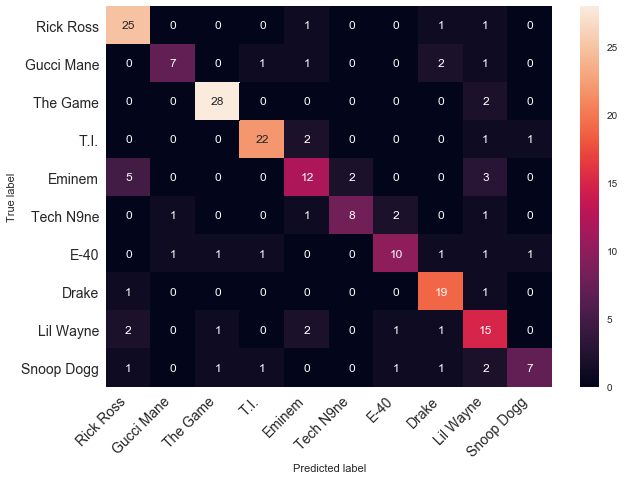

In [44]:
cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(
    cm, index=y_test.unique().tolist(), columns=y_test.unique().tolist()
)

fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)

plt.ylabel('True label')
plt.xlabel('Predicted label')

The classification report below just helps add some number to the confusion matrix. The following classification report is for Doc2Vec

In [45]:
print(classification_report(y_test, y_pred, target_names=y_test.unique().tolist()))

             precision    recall  f1-score   support

  Rick Ross       0.74      0.89      0.81        28
 Gucci Mane       0.78      0.58      0.67        12
   The Game       0.90      0.93      0.92        30
       T.I.       0.88      0.85      0.86        26
     Eminem       0.63      0.55      0.59        22
  Tech N9ne       0.80      0.62      0.70        13
       E-40       0.71      0.62      0.67        16
      Drake       0.76      0.90      0.83        21
  Lil Wayne       0.54      0.68      0.60        22
 Snoop Dogg       0.78      0.50      0.61        14

avg / total       0.76      0.75      0.75       204



This classification report is for TF-IDF

In [46]:
print(classification_report(y_test, tfidf_gs_clf.predict(X_test), target_names=y_test.unique().tolist()))

             precision    recall  f1-score   support

  Rick Ross       0.69      0.96      0.81        28
 Gucci Mane       0.78      0.58      0.67        12
   The Game       0.90      0.90      0.90        30
       T.I.       0.89      0.92      0.91        26
     Eminem       0.65      0.59      0.62        22
  Tech N9ne       0.75      0.69      0.72        13
       E-40       0.79      0.69      0.73        16
      Drake       0.70      0.90      0.79        21
  Lil Wayne       0.82      0.64      0.72        22
 Snoop Dogg       0.89      0.57      0.70        14

avg / total       0.79      0.78      0.77       204



Find correlation and statistical significance between f-measure

In [47]:
# f-measures
x = [0.81,0.67,0.92,0.86,0.59,0.70,0.67,0.83,0.60,0.61]
y = [0.81,0.67,0.90,0.91,0.62,0.72,0.73,0.79,0.72,0.70]
scipy.stats.pearsonr(x,y)

(0.9172961305945859, 0.00018506087636343437)

Compare vocabulary across models

In [53]:
len(set(tfidf_vocab).intersection(dbow_vocab))

2677

In [54]:
set(tfidf_vocab) - set(dbow_vocab)

set()

In [55]:
set(dbow_vocab) - set(tfidf_vocab)

{'a',
 'aaron',
 'abortion',
 'about',
 'above',
 'absurd',
 'ace',
 'across',
 'ad',
 'admire',
 'adrenaline',
 'after',
 'again',
 'against',
 'ahhhhh',
 'aims',
 'aka',
 'alert',
 'all',
 'allow',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'american',
 'americans',
 'ammo',
 'ammunition',
 'amsterdam',
 'an',
 'and',
 'another',
 'any',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'appears',
 'applauded',
 'appreciate',
 'are',
 'around',
 'as',
 'asap',
 'at',
 'atf',
 'attic',
 'audire',
 'auntie',
 'aussie',
 'autograph',
 'ayo',
 'back',
 'backseat',
 'bae',
 'baggage',
 'baghdad',
 'bagpipes',
 'bales',
 'bankroll',
 'bap',
 'be',
 'beans',
 'beard',
 'beatch',
 'became',
 'because',
 'become',
 'been',
 'before',
 'begins',
 'behavior',
 'behind',
 'being',
 'belaire',
 'belongs',
 'below',
 'bendin',
 'benzes',
 'beotch',
 'berserk',
 'beside',
 'between',
 'beverly',
 'beyond',
 'bezel',
 'bikinis',
 'bill',
 'birkin',
 'blades',


In [56]:
len(set(dbow_vocab) - set(tfidf_vocab))

771

<a name="miscellaneous"></a>
## 7. Miscellaneous

BOW vocabulary

In [57]:
bow.get_feature_names()

['aaahhh',
 'aah',
 'aalegra',
 'aaliyah',
 'aaron',
 'aauuaauuaaggghh',
 'abandon',
 'abandoned',
 'abercrombie',
 'able',
 'abomination',
 'aborted',
 'abortion',
 'abortions',
 'abracadabra',
 'absent',
 'absolute',
 'absolutely',
 'abstract',
 'absurd',
 'abundance',
 'abuse',
 'abusing',
 'ac',
 'acapella',
 'acapulco',
 'accelerants',
 'accent',
 'accents',
 'accept',
 'accepting',
 'accident',
 'accidentally',
 'acclimated',
 'accomplish',
 'accomplished',
 'accomplishments',
 'accord',
 'according',
 'account',
 'accountants',
 'accounts',
 'accusations',
 'accuse',
 'accustomed',
 'ace',
 'aces',
 'ache',
 'ached',
 'achievements',
 'achievin',
 'aching',
 'achoo',
 'acid',
 'acorn',
 'acquainted',
 'acquired',
 'acres',
 'acrobatics',
 'acros',
 'act',
 'actavis',
 'actin',
 'acting',
 'action',
 'actions',
 'activated',
 'active',
 'activist',
 'activists',
 'activity',
 'actor',
 'actors',
 'actress',
 'acts',
 'actual',
 'actually',
 'acupuncture',
 'acura',
 'ad',
 'adam'

Sample vocabulary extracted, demonstrates lack of stemming and removal of punctuation.

In [58]:
tfidf_vocab = tfidf.get_feature_names()
tfidf_vocab

['able',
 'accident',
 'account',
 'act',
 'actin',
 'acting',
 'action',
 'actually',
 'add',
 'addict',
 'addicted',
 'addiction',
 'admit',
 'advantage',
 'advice',
 'afford',
 'afraid',
 'aftermath',
 'age',
 'ago',
 'agree',
 'ah',
 'ahead',
 'ahh',
 'ai',
 'aight',
 'aim',
 'ain',
 'air',
 'ak',
 'alarm',
 'album',
 'albums',
 'ali',
 'alive',
 'alright',
 'amazing',
 'ambulance',
 'america',
 'angel',
 'angels',
 'anger',
 'angry',
 'animal',
 'animals',
 'answer',
 'anybody',
 'anymore',
 'apart',
 'apartment',
 'ape',
 'apologize',
 'apple',
 'arm',
 'arms',
 'army',
 'art',
 'artist',
 'artists',
 'ashamed',
 'ashes',
 'aside',
 'ask',
 'asked',
 'askin',
 'asking',
 'asleep',
 'ass',
 'asshole',
 'ate',
 'atlanta',
 'atlantic',
 'attack',
 'attempt',
 'attention',
 'attitude',
 'authority',
 'automatic',
 'avenue',
 'average',
 'avoid',
 'aw',
 'awake',
 'award',
 'aware',
 'away',
 'awkward',
 'aww',
 'ay',
 'aye',
 'ayy',
 'b',
 'babe',
 'babies',
 'baby',
 'background',
 

Doc2Vec vocabularly

In [59]:
model_dbow.wv.vocab

{'intro': <gensim.models.keyedvectors.Vocab at 0x1152915f8>,
 'oh': <gensim.models.keyedvectors.Vocab at 0x1155f7ac8>,
 'my': <gensim.models.keyedvectors.Vocab at 0x1165065c0>,
 'what': <gensim.models.keyedvectors.Vocab at 0x1156a4c50>,
 'have': <gensim.models.keyedvectors.Vocab at 0x11649bb70>,
 'i': <gensim.models.keyedvectors.Vocab at 0x116521630>,
 'done': <gensim.models.keyedvectors.Vocab at 0x11652dbe0>,
 'no': <gensim.models.keyedvectors.Vocab at 0x115647f28>,
 'ca': <gensim.models.keyedvectors.Vocab at 0x115647710>,
 'believe': <gensim.models.keyedvectors.Vocab at 0x115647e48>,
 'it': <gensim.models.keyedvectors.Vocab at 0x1156474a8>,
 'like': <gensim.models.keyedvectors.Vocab at 0x115647d30>,
 'got': <gensim.models.keyedvectors.Vocab at 0x115647358>,
 'the': <gensim.models.keyedvectors.Vocab at 0x1164f8978>,
 'whole': <gensim.models.keyedvectors.Vocab at 0x115af4208>,
 'world': <gensim.models.keyedvectors.Vocab at 0x115af4438>,
 'in': <gensim.models.keyedvectors.Vocab at 0x115